In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_percentage_error


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



USDEURO = fred.get_series("DEXUSEU")
USDEURO.name = "USDEURO"

df = pd.concat([USDEURO],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df['EUROUSD'] = 1 / df['USDEURO']
df.drop('index',axis=1,inplace=True)




cuda


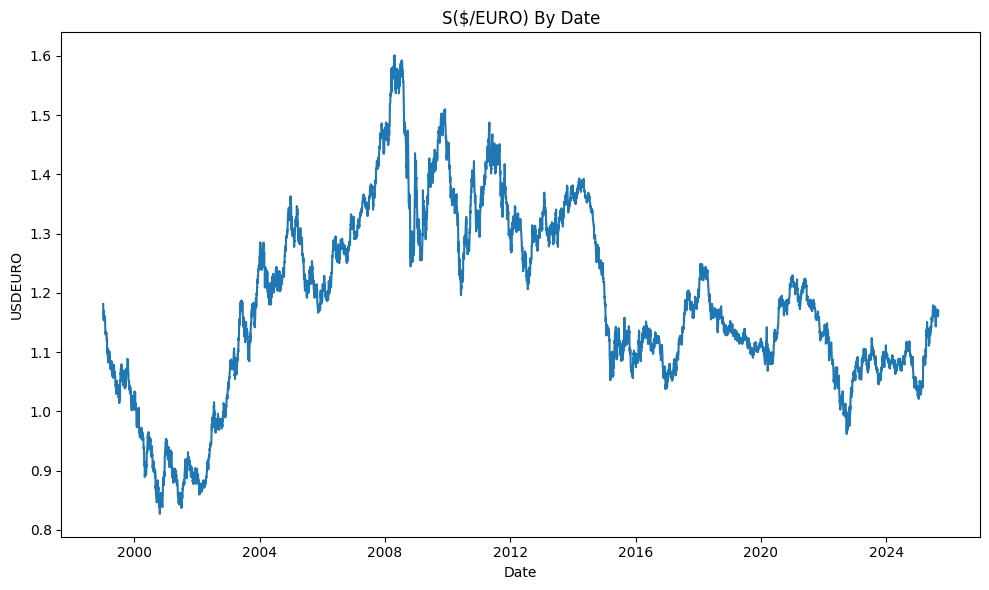

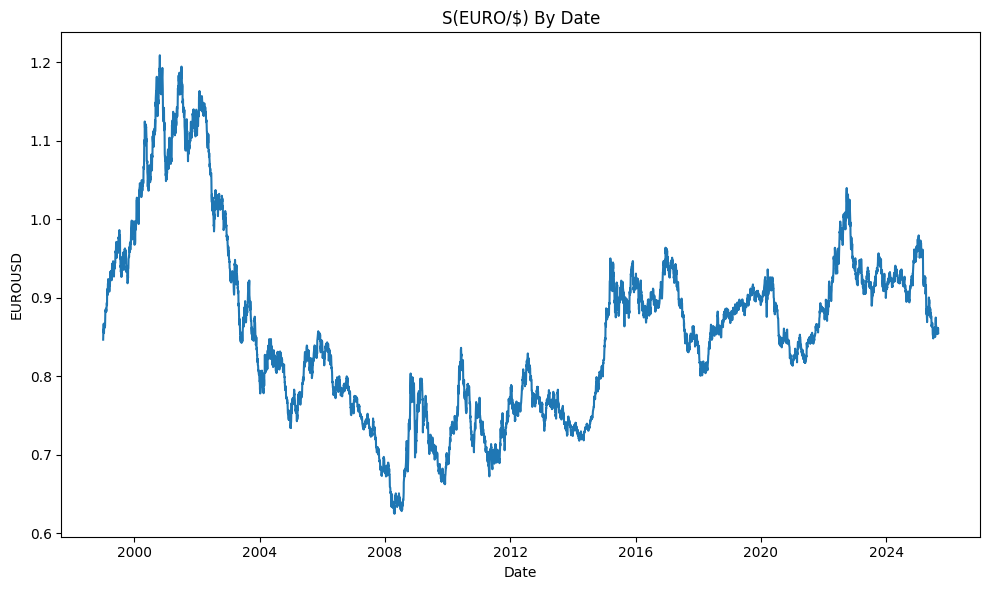

In [2]:
# S(EURO/USD)


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDEURO',data=df)
plt.title("S($/EURO) By Date")
plt.savefig("images/spotrate_S_usd_euro.png")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='EUROUSD',data=df)
plt.title("S(EURO/$) By Date")
plt.savefig("images/spotrate_eurousd.png")
plt.tight_layout()
plt.show()

In [4]:
df.drop('EUROUSD',inplace=True,axis=1)
df.drop_duplicates(inplace=True)
training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

model = GRU(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')






/tmp/ipykernel_95863/2644186548.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_95863/2644186548.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.5025; Test RSME: 0.329
Epoch: 1; train_RSEM: 0.4897; Test RSME: 0.3162
Epoch: 2; train_RSEM: 0.4768; Test RSME: 0.3033
Epoch: 3; train_RSEM: 0.464; Test RSME: 0.2904
Epoch: 4; train_RSEM: 0.4511; Test RSME: 0.2775
Epoch: 5; train_RSEM: 0.4383; Test RSME: 0.2645
Epoch: 6; train_RSEM: 0.4255; Test RSME: 0.2515
Epoch: 7; train_RSEM: 0.4126; Test RSME: 0.2384
Epoch: 8; train_RSEM: 0.3997; Test RSME: 0.2253
Epoch: 9; train_RSEM: 0.3868; Test RSME: 0.212
Epoch: 10; train_RSEM: 0.3739; Test RSME: 0.1987
Epoch: 11; train_RSEM: 0.3609; Test RSME: 0.1852
Epoch: 12; train_RSEM: 0.3479; Test RSME: 0.1717
Epoch: 13; train_RSEM: 0.3349; Test RSME: 0.158
Epoch: 14; train_RSEM: 0.3218; Test RSME: 0.1442
Epoch: 15; train_RSEM: 0.3088; Test RSME: 0.1304
Epoch: 16; train_RSEM: 0.2959; Test RSME: 0.1165
Epoch: 17; train_RSEM: 0.283; Test RSME: 0.1027
Epoch: 18; train_RSEM: 0.2703; Test RSME: 0.08898
Epoch: 19; train_RSEM: 0.2578; Test RSME: 0.07554
Epoch: 20; train_RSEM: 0.2456; Te

In [5]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test_np,pred_np)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2*100:.2f}%')


test_dates = df.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

RMSE: 0.006683281157165766
R2 Score: 97.41%
         Date  Actual Spot Rate  Predicted Spot Rate
0  2022-12-30            1.0698             1.066197
1  2023-01-03            1.0559             1.069150
2  2023-01-04            1.0620             1.055479
3  2023-01-05            1.0522             1.061475
4  2023-01-06            1.0619             1.051844
5  2023-01-09            1.0759             1.061377
6  2023-01-10            1.0737             1.075157
7  2023-01-11            1.0740             1.072990
8  2023-01-12            1.0823             1.073286
9  2023-01-13            1.0811             1.081466
10 2023-01-17            1.0793             1.080282
11 2023-01-18            1.0827             1.078508
12 2023-01-19            1.0810             1.081860
13 2023-01-20            1.0831             1.080184
14 2023-01-23            1.0865             1.082255
15 2023-01-24            1.0873             1.085609
16 2023-01-25            1.0901             1.086398
17

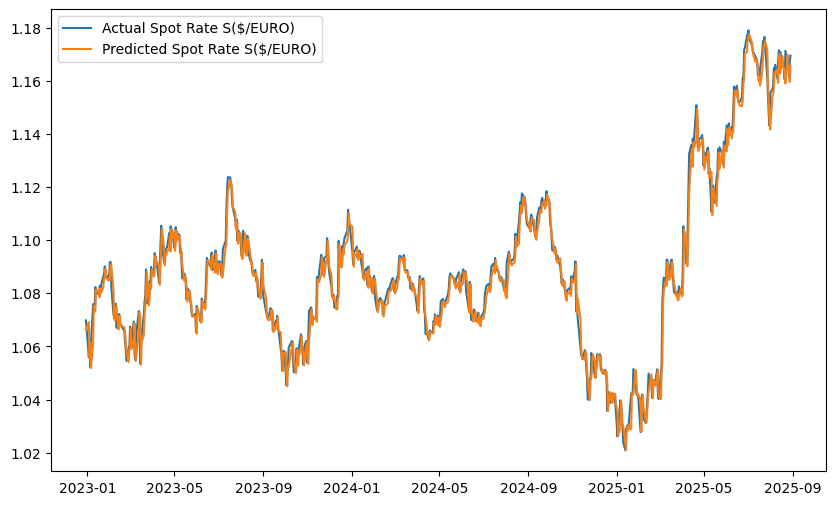

In [6]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/EURO)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/EURO)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()